# Linear Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# from theano import shared
import arviz as az
import pymc as pm
az.style.use('arviz-darkgrid')

In [3]:
import scipy.stats as stats

## Simple linear regression

In [4]:
np.random.seed(1)
N = 100
α_real = 2.5
β_real = 0.9
ϵ_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = α_real + β_real * x
y = y_real + ϵ_real

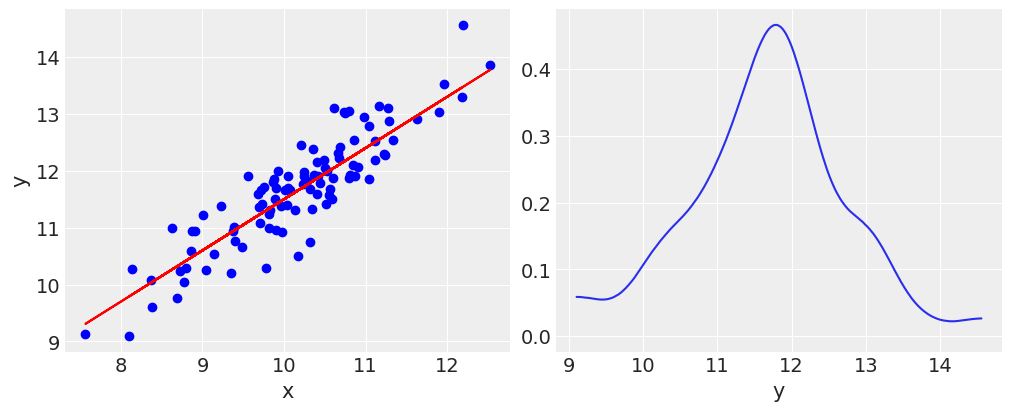

In [5]:
_, ax = plt.subplots(1, 2, figsize=(10, 4),  constrained_layout=True)

ax[0].scatter(x, y, color='b')
ax[0].plot(x, y_real, 'r')
ax[0].set(xlabel='x', ylabel='y')
az.plot_kde(y, ax=ax[1])
ax[1].set(xlabel='y')
# plt.savefig('images/ch4/lr.png')
plt.show()

In [6]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    # trace_g = pm.sample(2000, tune=1000, return_inferencedata=True)
    # trace_g.to_netcdf("data/ch4/lr_simple.nc")
    trace_g = az.from_netcdf("../../data-pymc/ch4/lr_simple.nc")

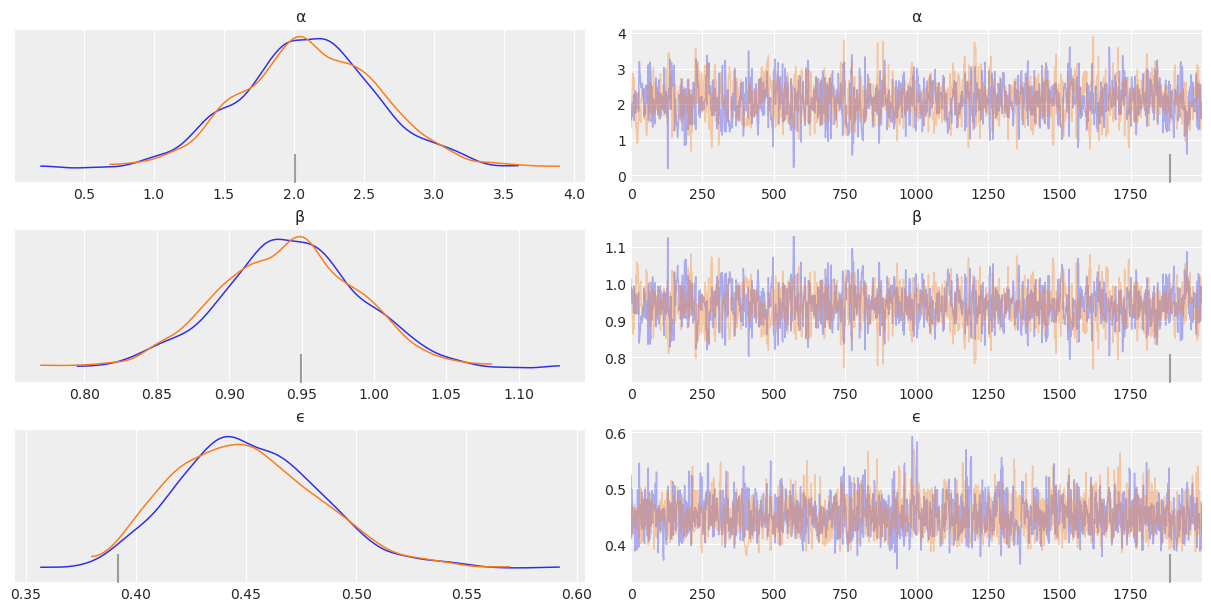

In [7]:
az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ'], compact=False);

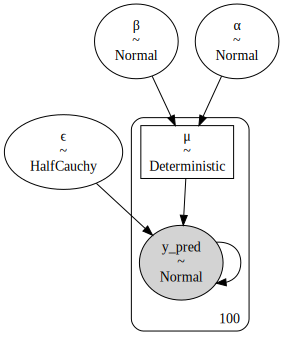

In [8]:
pm.model_to_graphviz(model_g)

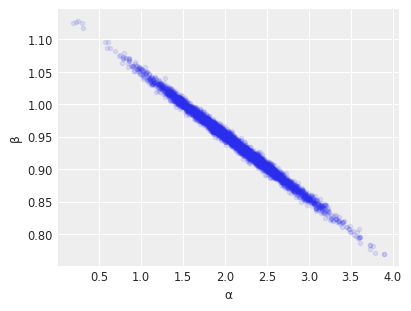

In [9]:
az.plot_pair(trace_g,
             var_names=['α', 'β'],
             figsize=(4, 3),
             scatter_kwargs={'alpha': 0.1})
# plt.savefig('images/ch4/lr_pair.png')
plt.show()

### Interpreting the posterior

In [10]:
α_m = trace_g.posterior['α'].mean().values
β_m = trace_g.posterior['β'].mean().values
# ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)
# az.to_netcdf(ppc, "data/ch4/lr_simple_ppc.nc")
ppc = az.from_netcdf("../../data-pymc/ch4/lr_simple_ppc.nc")

/opt/homebrew/Caskroom/mambaforge/base/envs/kaggle/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/kaggle/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


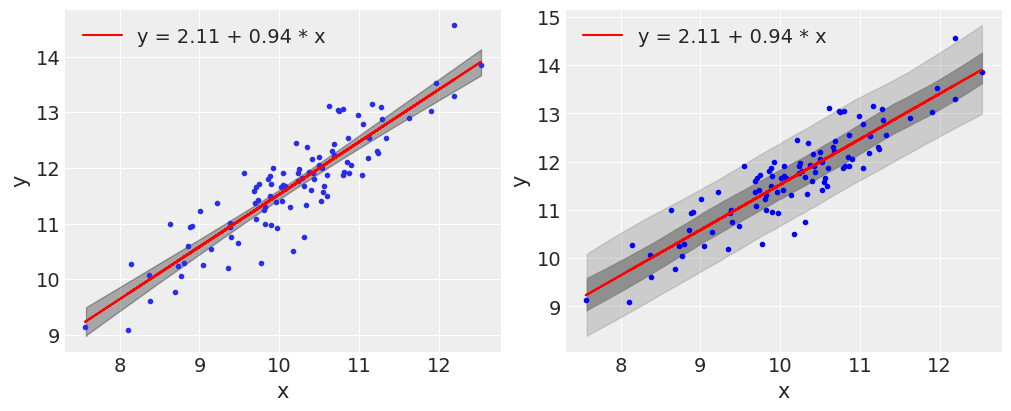

In [11]:
_, axes = plt.subplots(1, 2, figsize=(10, 4),  constrained_layout=True)

axes[0].plot(x, y, 'C0.')
axes[0].plot(x, α_m + β_m * x, c='r', label=f'y = {α_m:.2f} + {β_m:.2f} * x')

az.plot_hdi(x,
            trace_g.posterior['μ'],
            hdi_prob=0.94,
            fill_kwargs={'alpha': .3},
            color='k',
            ax=axes[0])

axes[0].set(xlabel='x', ylabel='y')
axes[0].legend()

axes[1].plot(x, y, 'b.')
axes[1].plot(x, α_m + β_m * x, c='r', label=f'y = {α_m:.2f} + {β_m:.2f} * x')

az.plot_hdi(x,
            ppc.posterior['y_pred'],
            hdi_prob=0.94,
            color='gray',
            fill_kwargs={'alpha': .3},
            ax=axes[1])
az.plot_hdi(x,
            ppc.posterior['y_pred'],
            hdi_prob=0.5,
            color='gray',
            fill_kwargs={'alpha': .8},
            ax=axes[1])

axes[1].set(xlabel='x', ylabel='y')
axes[1].legend()
# plt.savefig('images/ch4/lr_posterior.png')
plt.show()

In [12]:
az.r2_score(y, ppc.posterior['y_pred'])

ValueError: 0 not found in array dimensions ('chain', 'draw')

### The multivariate normal distribution 
Actually the bivariate

In [13]:
from itertools import product

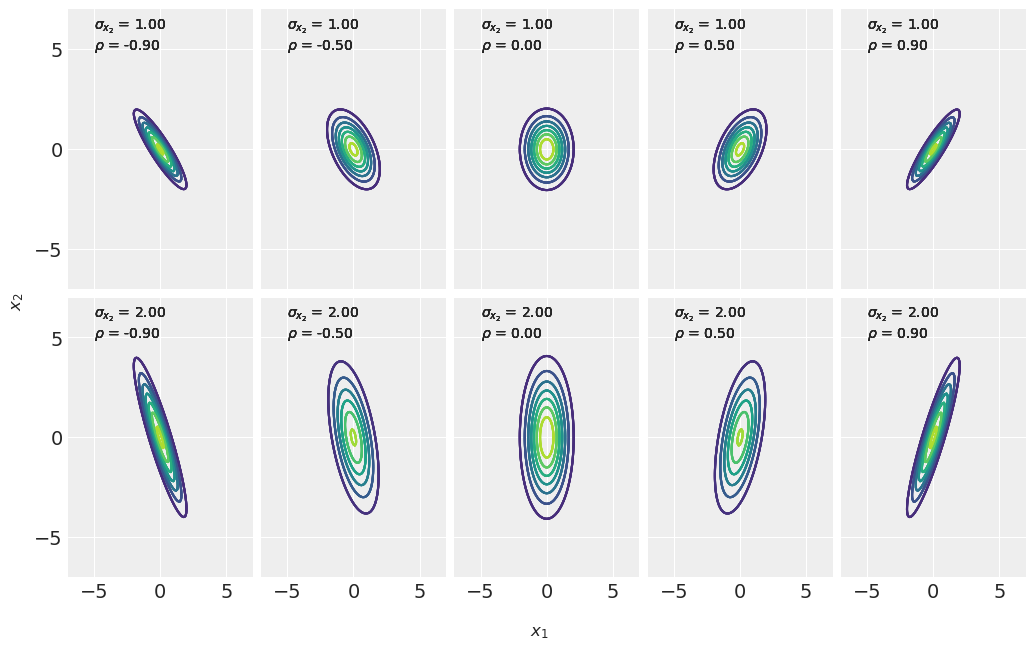

In [14]:
σ_x1 = 1
σs_x2 = [1, 2]
ρs = [-0.90, -0.5, 0, 0.5, 0.90]

params = product(σs_x2, ρs)

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2, ))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, axes = plt.subplots(len(σs_x2),
                       len(ρs),
                       sharex=True,
                       sharey=True,
                       figsize=(10, 6),
                       
                       constrained_layout=True)

for ax, param in zip(axes.flatten(), params):
    for j in range(5):
        σ_x2, ρ = param
        cov = [[σ_x1**2, σ_x1 * σ_x2 * ρ], [σ_x1 * σ_x2 * ρ, σ_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax.contour(k, l, rv.pdf(pos))
        ax.set(xlim=(-7, 7), ylim=(-7, 7), yticks=[-5, 0, 5])
        ax.text(-5, 5, s=f'$σ_{{x_2}}$ = {σ_x2:3.2f}\n$ρ$ = {ρ:3.2f}')

f.text(0.5, -0.05, '$x_1$', fontsize='large')
f.text(-0.02, 0.5, '$x_2$', fontsize='large', rotation=90)
# plt.savefig('images/ch4/mvn_pearson.png')
plt.show()

In [15]:
data = np.stack((x, y)).T

with pm.Model() as pearson_model:

    μ = pm.Normal('μ', mu=data.mean(0), sd=10, shape=2)

    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1., 1.)
    r2 = pm.Deterministic('r2', ρ**2)

    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
                         [σ_1*σ_2*ρ, σ_2**2]))

    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data)

    # trace_p = pm.sample(1000, return_inferencedata=True)
    # trace_p.to_netcdf("data/ch4/lr_mvn.nc")
    trace_p = az.from_netcdf("../../data-pymc/ch4/lr_mvn.nc")

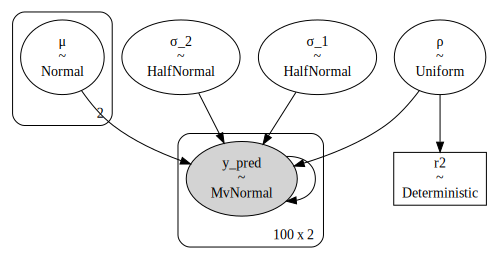

In [16]:
pm.model_to_graphviz(pearson_model)

array([[<AxesSubplot:title={'center':'r2'}>,
        <AxesSubplot:title={'center':'r2'}>]], dtype=object)

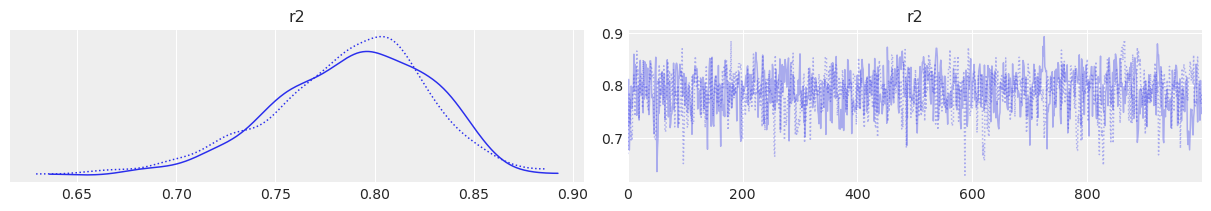

In [17]:
az.plot_trace(trace_p, var_names=['r2'])

In [18]:
az.summary(trace_p, var_names=['r2'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
r2  0.788  0.039   0.717    0.859      0.001    0.001     786.0     994.0   

    r_hat  
r2    1.0

## Robust linear regression

In [19]:
ans = sns.load_dataset("anscombe")
ans.head()

dataset     x     y
0       I  10.0  8.04
1       I   8.0  6.95
2       I  13.0  7.58
3       I   9.0  8.81
4       I  11.0  8.33

In [21]:
x_3 = ans.query("dataset == 'III'")['x']
y_3 = ans.query("dataset == 'III'")['y']
x_3 = x_3 - x_3.mean()

KeyError: 0

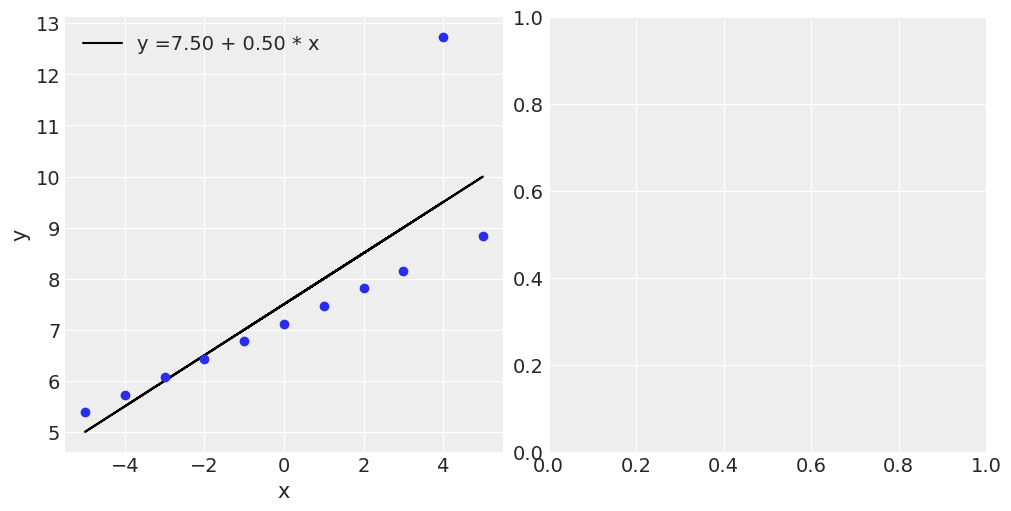

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

β_c, α_c = stats.linregress(x_3, y_3)[:2]

ax[0].plot(x_3, (α_c + β_c * x_3), 'k', label=f'y ={α_c:.2f} + {β_c:.2f} * x')

ax[0].plot(x_3, y_3, 'C0o')
ax[0].set(xlabel='x', ylabel='y')
ax[0].legend(loc=0)

az.plot_kde(values=y_3, ax=ax[1], rug=True)
ax[1].set(ylabel='y', yticks=[])
# plt.savefig('images/ch4/ans.png')

In [ ]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)

    # trace_t = pm.sample(2000, return_inferencedata=True)
    # trace_t.to_netcdf("data/ch4/ans_t.nc")
    trace_t = az.from_netcdf("../../data-pymc/ch4/ans_t.nc")

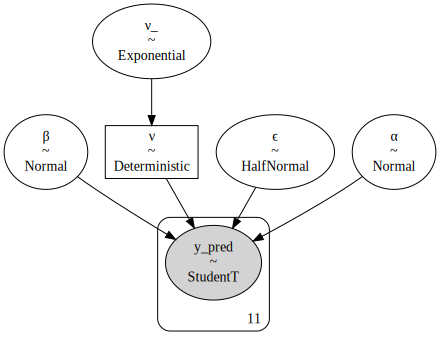

In [ ]:
pm.model_to_graphviz(model_t)

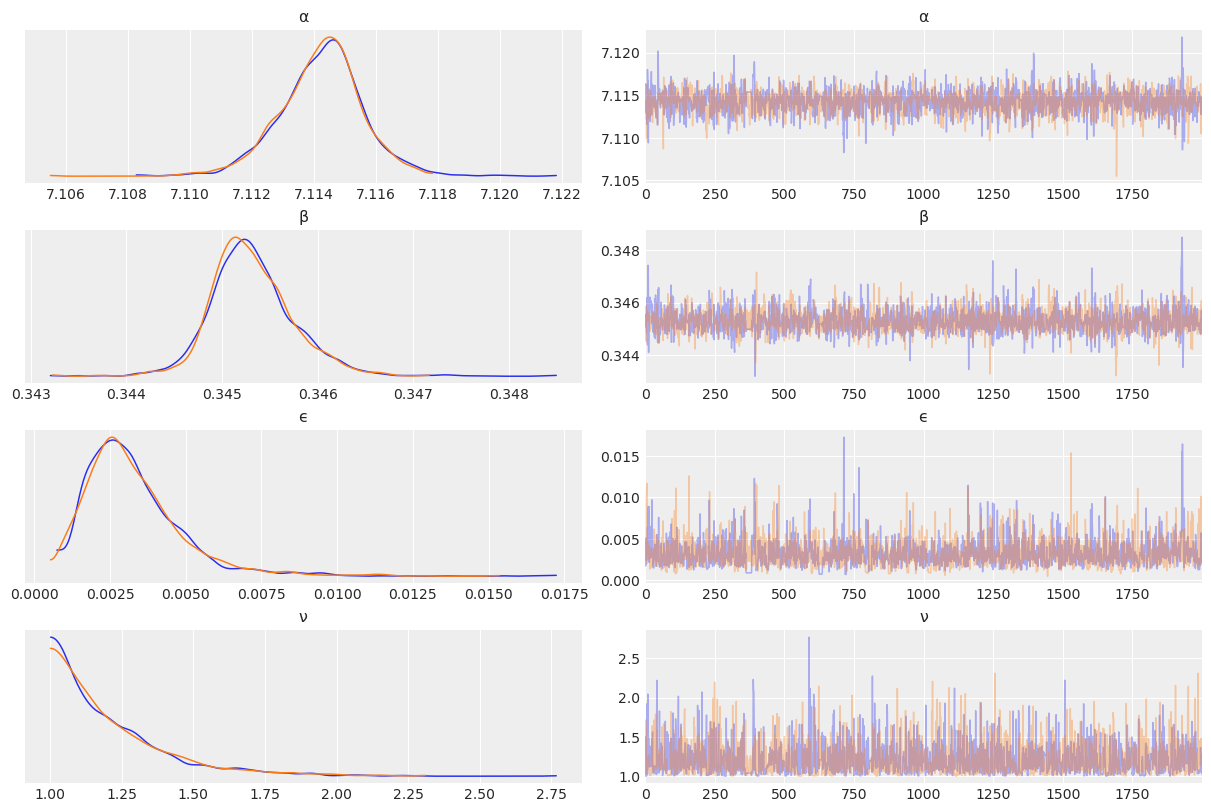

In [ ]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.plot_trace(trace_t, var_names=varnames, compact=False);

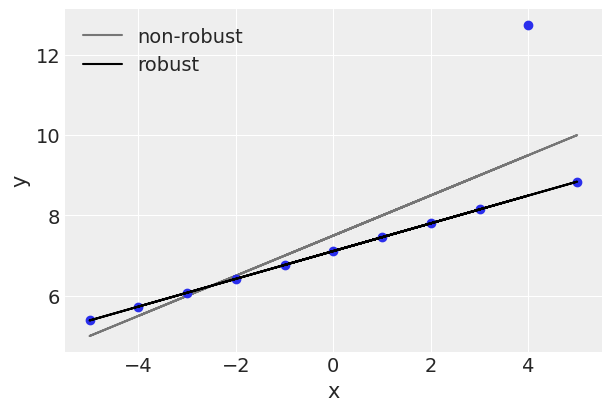

In [ ]:
β_c, α_c = stats.linregress(x_3, y_3)[:2]
α_m = trace_t.posterior['α'].mean().values
β_m = trace_t.posterior['β'].mean().values

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.plot(x_3, (α_c + β_c * x_3), 'k', label='non-robust', alpha=0.5)
ax.plot(x_3, y_3, 'C0o')
ax.plot(x_3, α_m + β_m * x_3, c='k', label='robust')

ax.set(xlabel='x', ylabel='y')
ax.legend()
# plt.savefig('images/ch4/ans_robust.png')
plt.show();

In [ ]:
az.summary(trace_t, var_names=varnames)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α  7.114  0.001   7.112    7.117      0.000    0.000    2332.0    2150.0   
β  0.345  0.000   0.345    0.346      0.000    0.000    2643.0    1913.0   
ϵ  0.003  0.002   0.001    0.006      0.000    0.000    1394.0     635.0   
ν  1.211  0.206   1.000    1.595      0.004    0.003    1527.0    1004.0   

   r_hat  
α    1.0  
β    1.0  
ϵ    1.0  
ν    1.0

In [ ]:
# az.summary(trace_t, var_names=varnames).to_markdown()

In [ ]:
with model_t:
    ppc = pm.sample_posterior_predictive(trace_t, samples=200, random_seed=2)
    data_ppc = az.from_pymc3(posterior_predictive=ppc)

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


[(4.0, 12.0)]

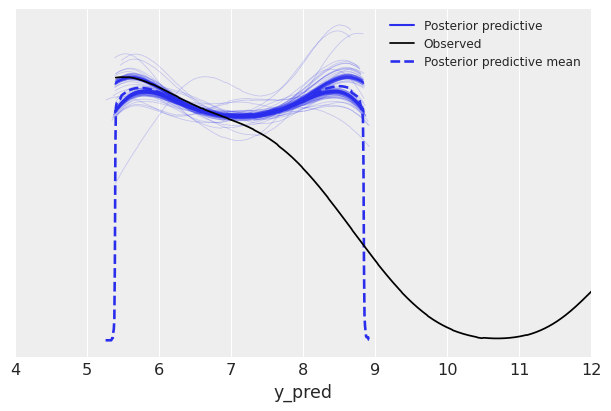

In [ ]:
ax = az.plot_ppc(data_ppc, figsize=(6, 4), mean=True)
ax.set(xlim=(4, 12))
# plt.savefig('images/ch4/ans_ppc.png')

## Hierarchical linear regression

In [ ]:
N = 20
M = 8
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7])

In [ ]:
np.random.seed(314)

α_real = np.random.normal(2.5, 0.5, size=M)
β_real = np.random.beta(6, 1, size=M)
ϵ_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = α_real[idx] + β_real[idx] * x_m + ϵ_real

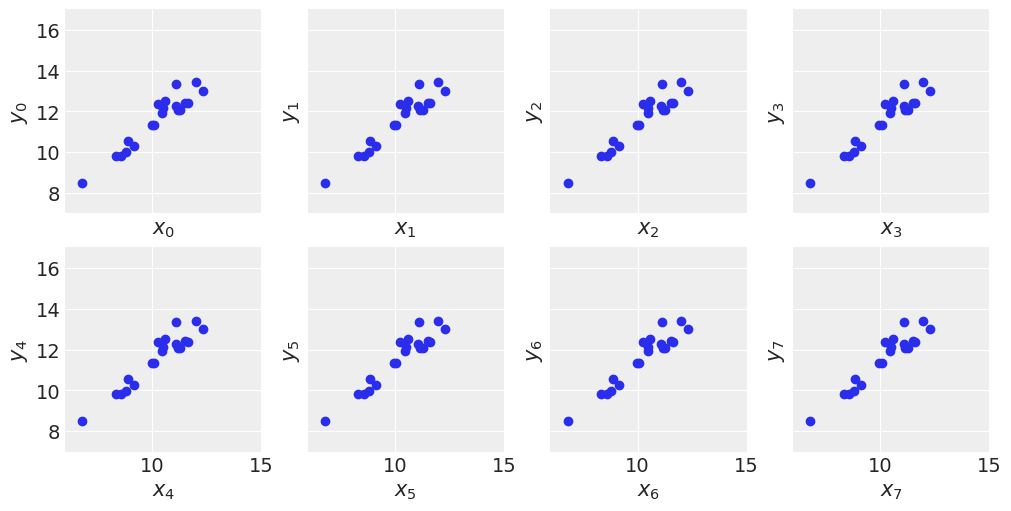

In [ ]:
_, axes = plt.subplots(2,
                       4,
                       figsize=(10, 5),
                       sharex=True,
                       sharey=True,
                       constrained_layout=True)

for ind, ax in enumerate(axes.flatten()):
    ax.scatter(x_m[0:N], y_m[0:N])
    ax.set(xlabel=f'$x_{ind}$',
           ylabel=f'$y_{ind}$',
           xlim=(6, 15),
           ylim=(7, 17))
# plt.savefig('images/ch4/lr_h.png')

In [ ]:
with pm.Model() as unpooled_model:
    α_samp = pm.Normal('α_samp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    α = pm.Deterministic('α', α_samp - β * x_m.mean())

    y_pred = pm.StudentT('y_pred', mu=α, sd=ϵ, nu=ν, observed=y_m)

    # trace_up = pm.sample(2000, return_inferencedata=True)
    # trace_up.to_netcdf("data/ch4/lr_h.nc")
    trace_up = az.from_netcdf("../../data-pymc/ch4/lr_h.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_samp]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 292 seconds.


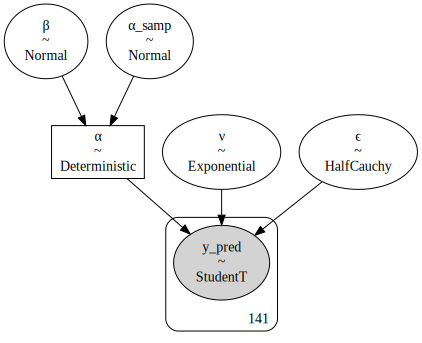

In [ ]:
pm.model_to_graphviz(unpooled_model)

In [ ]:
with pm.Model() as pooled_model:
    # hyper-priors
    α_samp_μ = pm.Normal('α_samp_μ', mu=0, sd=10)
    α_samp_σ = pm.HalfNormal('α_samp_σ', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_samp = pm.Normal('α_samp', mu=α_samp_μ, sd=α_samp_σ)
    β = pm.Normal('β', mu=β_μ, sd=β_σ)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    α = pm.Deterministic('α', α_samp - β * x_m.mean())
    # α_μ = pm.Deterministic('α_μ', α_samp_μ - β_μ * x_m.mean())
    # α_σ = pm.Deterministic('α_σ', α_samp_σ - β_μ * x_m.mean())

    y_pred = pm.StudentT('y_pred',
                         mu=α,
                         sd=ϵ,
                         nu=ν,
                         observed=y_m)

    # trace_hm = pm.sample(2000, return_inferencedata=True)
    # trace_hm.to_netcdf("data/ch4/ans_h.nc")
    trace_hm = az.from_netcdf("../../data-pymc/ch4/ans_h.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_samp, β_σ, β_μ, α_samp_σ, α_samp_μ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 356 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


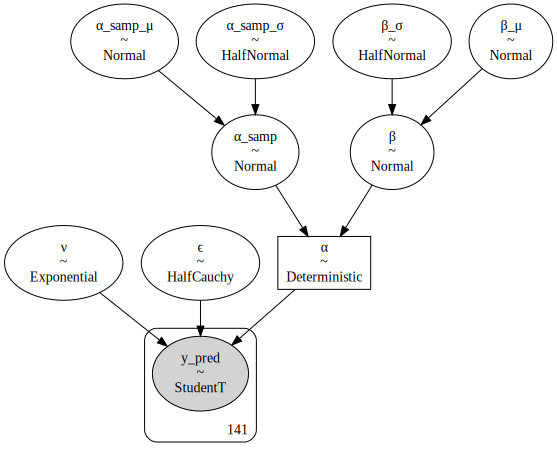

In [ ]:
pm.model_to_graphviz(pooled_model)

In [ ]:
with pooled_model:
    α_μ = pm.Deterministic('α_μ', α_samp_μ - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_σ', α_samp_σ - β_μ * x_m.mean())

Text(0.5, 0.98, 'Unpooled Model vs. Hierarchical Model\n')

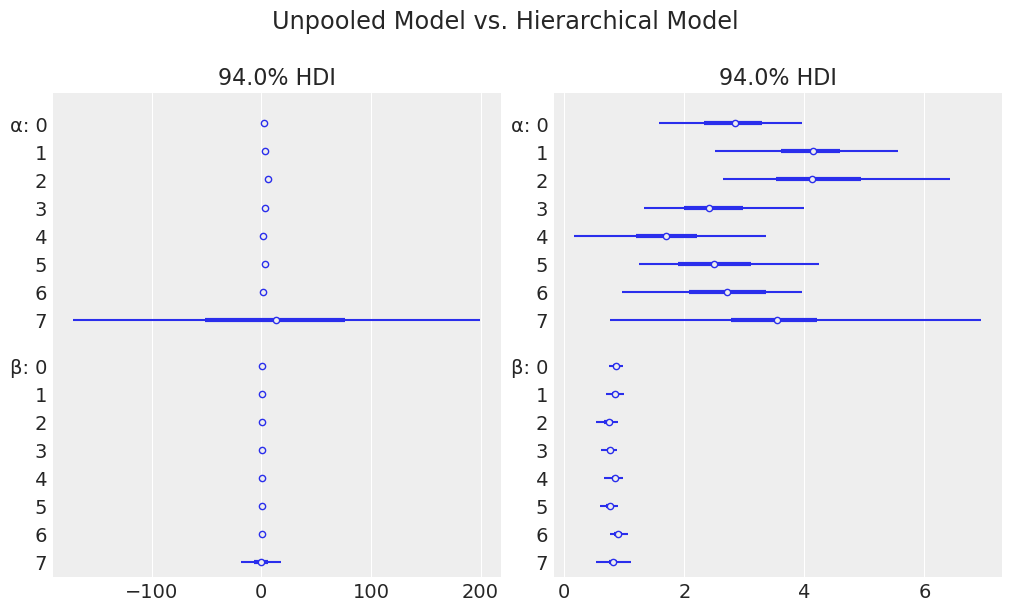

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(10, 6),  constrained_layout=True)

az.plot_forest(trace_up, var_names=['α', 'β'], combined=True, ax=axes[0])
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True, ax=axes[1])
plt.suptitle('Unpooled Model vs. Hierarchical Model\n', fontsize='xx-large')
# plt.savefig('images/ch4/lr_h_forest.png')

In [ ]:
from itertools import islice

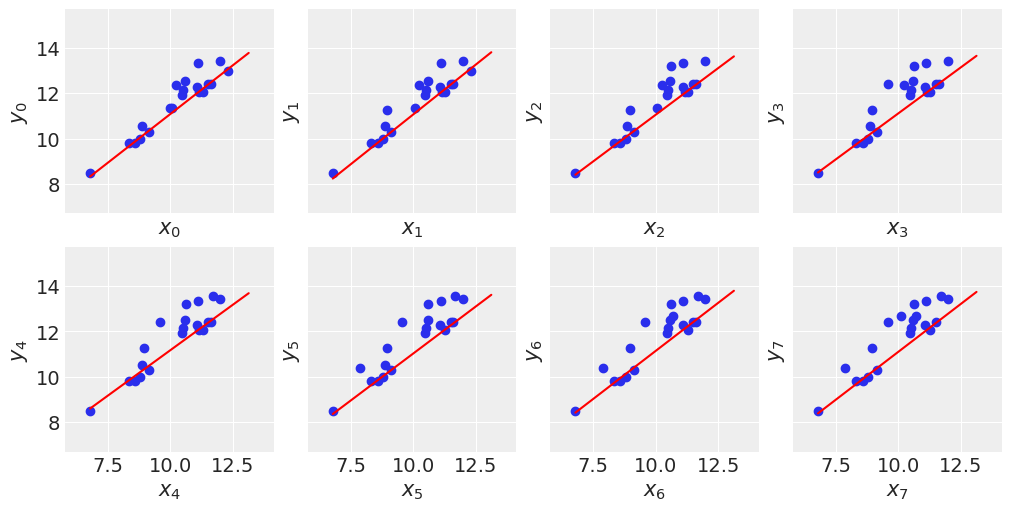

In [ ]:
_, axes = plt.subplots(2,
                       4,
                       figsize=(10, 5),
                       sharex=True,
                       sharey=True,
                       constrained_layout=True)

x_range = np.linspace(x_m.min(), x_m.max(), 10)

for ind, ax in enumerate(axes.flatten()):
    α_m = trace_hm.posterior['α'][:, ind].mean().values
    β_m = trace_hm.posterior['β'][:, ind].mean().values
    ax.scatter(x_m[ind:ind + N], y_m[ind:ind + N])
    ax.set(xlabel=f'$x_{ind}$', ylabel=f'$y_{ind}$')

    ax.plot(x_range,
            α_m + β_m * x_range,
            c='r',
            label=f'y = {α_m:.2f} + {β_m:.2f} * x')
    ax.set(xlim=(x_m.min() - 1, x_m.max() + 1),
           ylim=(y_m.min() - 1, y_m.max() + 1))

# plt.savefig('images/ch4/lr_h_fit.png')

## Polynomial regression

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

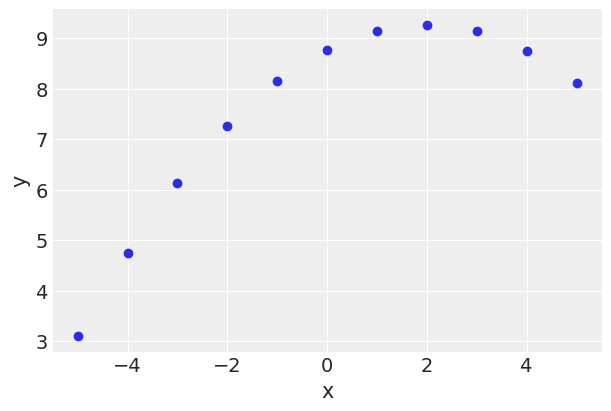

In [ ]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

x_2 = ans.query("group == 'II'")['x']
y_2 = ans.query("group == 'II'")['y']
x_2 = x_2 - x_2.mean()

ax.scatter(x_2, y_2)
ax.set(xlabel='x', ylabel='y')

In [ ]:
with pm.Model() as poly_model:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β_1 = pm.Normal('β_1', mu=0, sd=1)
    β_2 = pm.Normal('β_2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    mu = α + β_1 * x_2 + β_2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)

    # trace_poly = pm.sample(2000, return_inferencedata=True)
    # trace_poly.to_netcdf("data/ch4/ans_poly.nc")
    trace_poly = az.from_netcdf("../../data-pymc/ch4/ans_poly.nc")

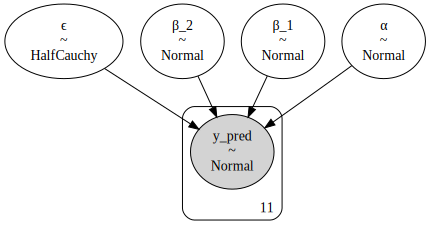

In [ ]:
pm.model_to_graphviz(poly_model)

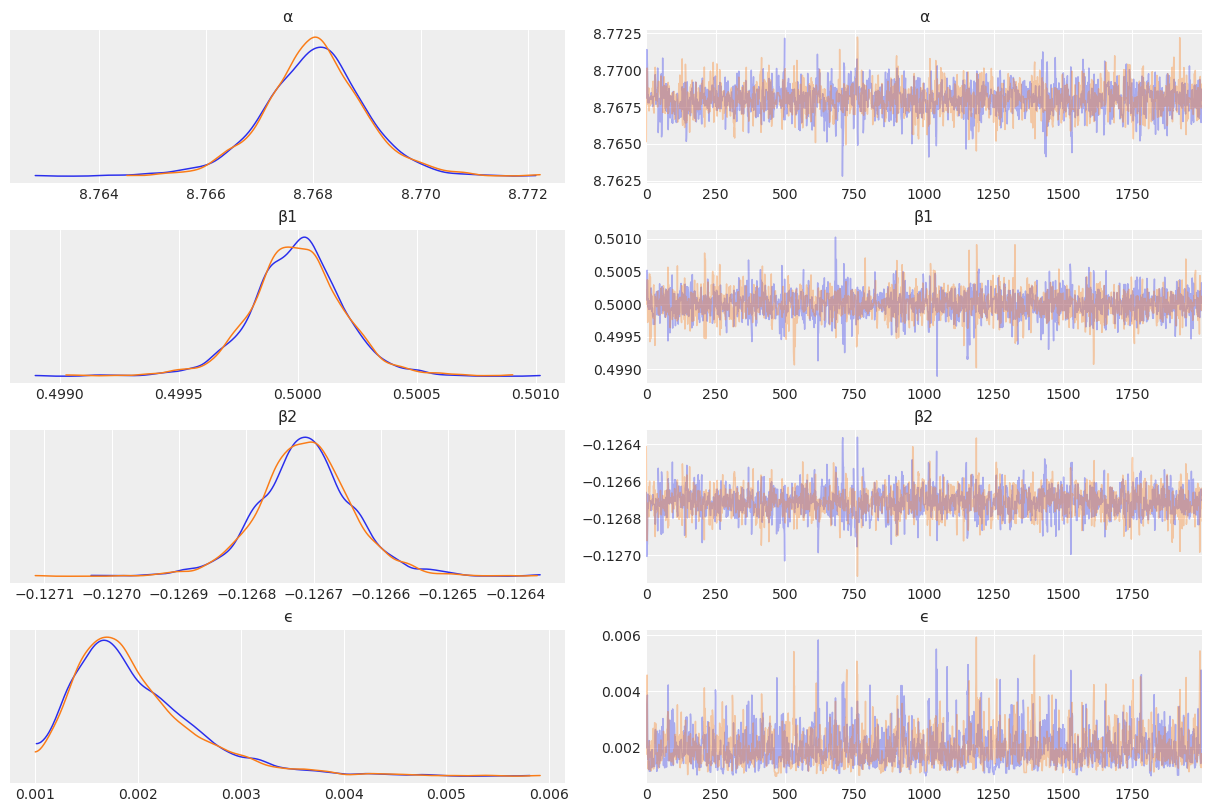

In [ ]:
az.plot_trace(trace_poly, compact=False);

In [ ]:
az.summary(trace_poly)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   8.768  0.001   8.766    8.770        0.0      0.0    1651.0    1592.0   
β1  0.500  0.000   0.500    0.500        0.0      0.0    2397.0    2060.0   
β2 -0.127  0.000  -0.127   -0.127        0.0      0.0    1725.0    1814.0   
ϵ   0.002  0.001   0.001    0.003        0.0      0.0    1129.0     913.0   

    r_hat  
α     1.0  
β1    1.0  
β2    1.0  
ϵ     1.0

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

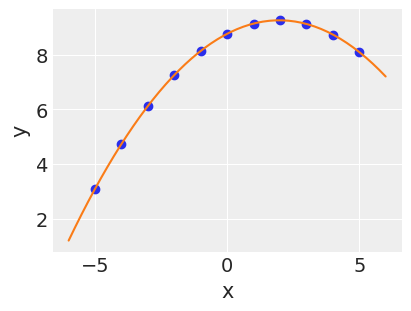

In [ ]:
_, ax = plt.subplots(figsize=(4, 3), dpi=100)

x_p = np.linspace(-6, 6)

α_mp = trace_poly.posterior['α'].mean().values
β1_mp = trace_poly.posterior['β1'].mean().values 
β2_mp = trace_poly.posterior['β2'].mean().values

y_p = α_mp + β1_mp * x_p + β2_mp * x_p**2

ax.scatter(x_2, y_2)
ax.plot(x_p, y_p, c='C1')
ax.set(xlabel='x', ylabel='y')
# plt.savefig('images/ch4/ans_poly.png')

## Multiple Linear regression

In [ ]:
np.random.seed(314)
N = 100
α_real = 2.5
β_real = [0.9, 1.5]
ϵ_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = α_real + np.dot(X, β_real) + ϵ_real

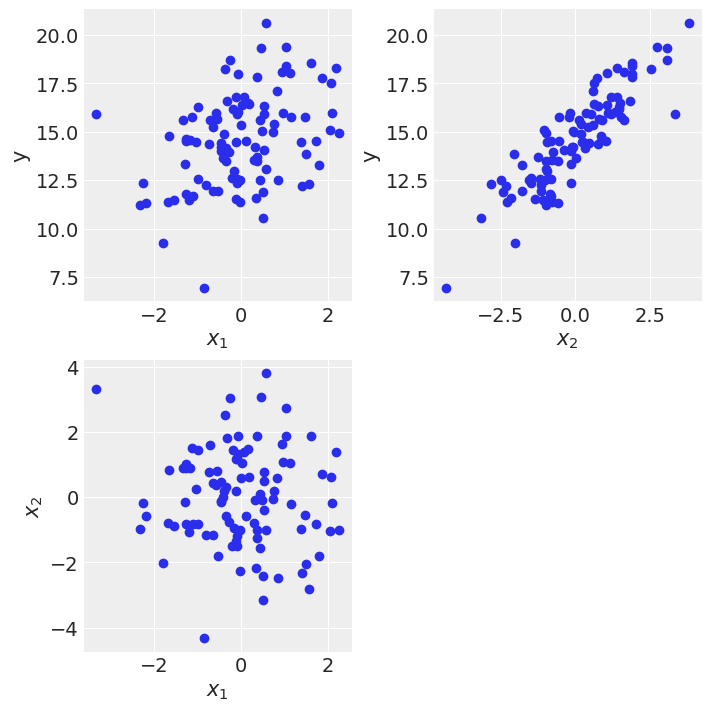

In [ ]:
def scatter_plot(x, y):
    plt.figure(figsize=(7, 7))

    for idx, x_i in enumerate(x.T):
        ax = plt.subplot(2, 2, idx + 1)
        ax.scatter(x_i, y)
        ax.set(xlabel=f'$x_{idx+1}$', ylabel=f'y')

    ax = plt.subplot(2, 2, idx + 2)
    ax.scatter(x[:, 0], x[:, 1])
    ax.set(xlabel=f'$x_{idx}$', ylabel=f'$x_{idx+1}$')

scatter_plot(X_centered, y)
# plt.savefig('images/ch4/multi.png')

In [ ]:
with pm.Model() as multi_model:
    α_samp = pm.Normal('α_samp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_samp + pm.math.dot(X_centered, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    # trace_mlr = pm.sample(2000, return_inferencedata=True)
    # trace_mlr.to_netcdf("data/ch4/lr_mlabel.nc")
    trace_mlr = az.from_netcdf("../../data-pymc/ch4/lr_mlabel.nc")

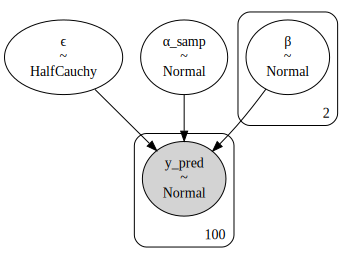

In [ ]:
pm.model_to_graphviz(multi_model)

In [ ]:
with multi_model:
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

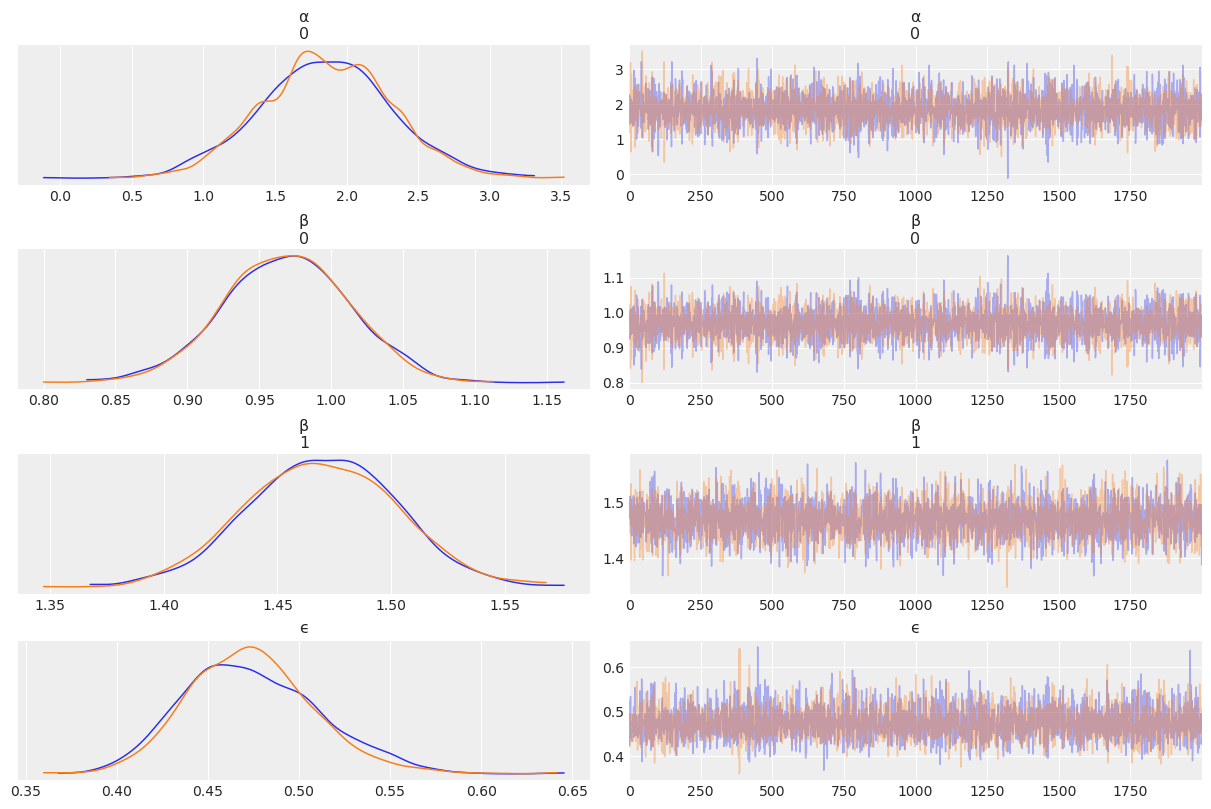

In [ ]:
az.plot_trace(trace_mlr, var_names=['α', 'β', 'ϵ'], compact=False);

In [ ]:
az.summary(trace_mlr, var_names=['α', 'β', 'ϵ'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α[0]  1.853  0.455   0.984    2.695      0.006    0.004    5883.0    3076.0   
β[0]  0.969  0.044   0.888    1.051      0.001    0.000    6087.0    3168.0   
β[1]  1.470  0.033   1.407    1.530      0.000    0.000    5616.0    3093.0   
ϵ     0.474  0.036   0.408    0.542      0.000    0.000    6469.0    2805.0   

      r_hat  
α[0]    1.0  
β[0]    1.0  
β[1]    1.0  
ϵ       1.0

In [ ]:
# az.summary(trace_mlr, var_names=['α', 'β', 'ϵ']).to_markdown()

## Confounding variables and redundant variables

In [ ]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T
X.shape

(100, 2)

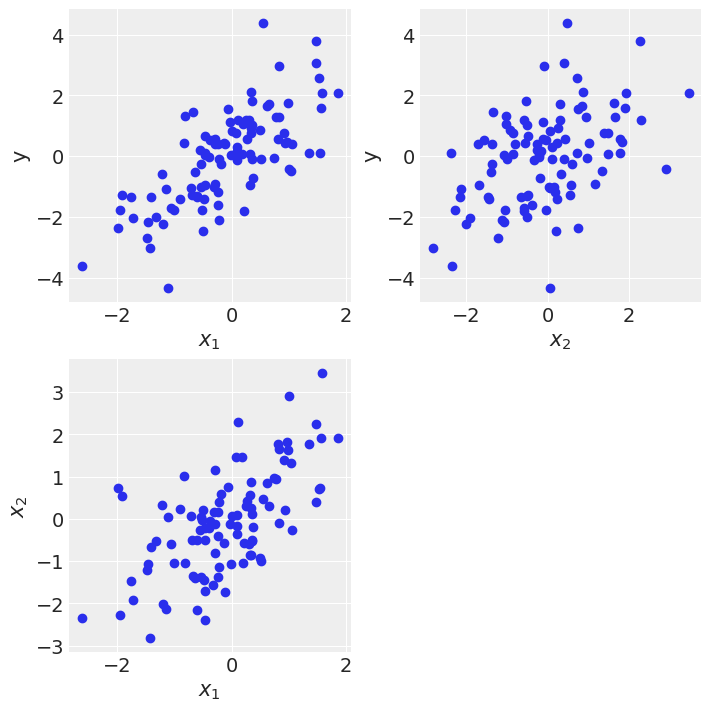

In [ ]:
scatter_plot(X, y)

In [ ]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β_1 = pm.Normal('β_1', mu=0, sd=10)
    β_2 = pm.Normal('β_2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β_1 * X[:, 0] + β_2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    # trace_x1x2 = pm.sample(2000, return_inferencedata=True)
    # trace_x1x2.to_netcdf("data/ch4/lr_mlabel2.nc")
    trace_x1x2 = az.from_netcdf("../../data-pymc/ch4/lr_mlabel2.nc")

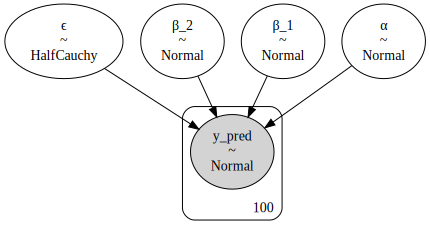

In [ ]:
pm.model_to_graphviz(m_x1x2)

In [ ]:
with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β_1 = pm.Normal('β_1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β_1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    # trace_x1 = pm.sample(2000, return_inferencedata=True)
    # trace_x1.to_netcdf("data/ch4/lr_mlabel11.nc")
    trace_x1 = az.from_netcdf("../../data-pymc/ch4/lr_mlabel11.nc")

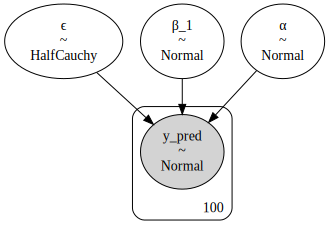

In [ ]:
pm.model_to_graphviz(m_x1)

In [ ]:
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β_2 = pm.Normal('β_2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β_2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    # trace_x2 = pm.sample(2000, return_inferencedata=True)
    # trace_x2.to_netcdf("data/ch4/lr_mlabel12.nc")
    trace_x2 = az.from_netcdf("../../data-pymc/ch4/lr_mlabel12.nc")

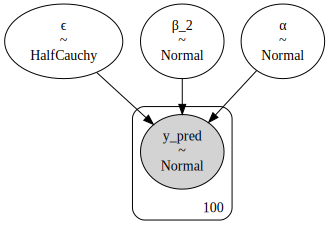

In [ ]:
pm.model_to_graphviz(m_x2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

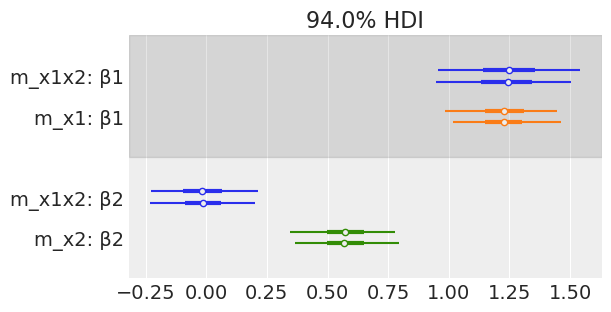

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=False,
               colors='cycle',
               figsize=(6, 3))

# plt.savefig('images/ch4/var_rebundant.png')

In [ ]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

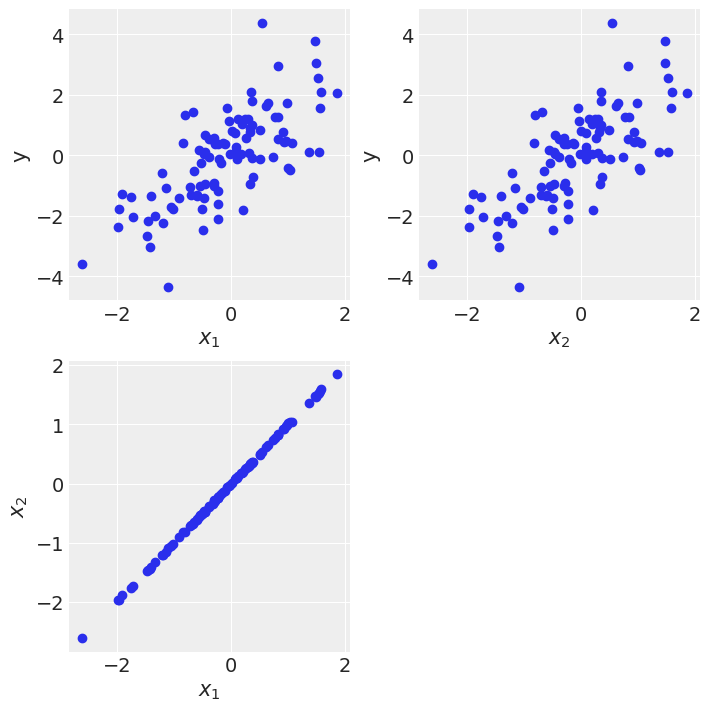

In [ ]:
scatter_plot(X, y)
# plt.savefig('images/ch4/lr_mcol.png')

In [ ]:
with pm.Model() as mcol_model:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    # trace_red = pm.sample(2000, return_inferencedata=True)
    # trace_red.to_netcdf("data/ch4/lr_m.nc")
    trace_red = az.from_netcdf("../../data-pymc/ch4/lr_m.nc")

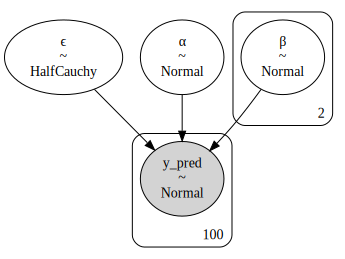

In [ ]:
pm.model_to_graphviz(mcol_model)

<AxesSubplot:xlabel='β\n0', ylabel='β\n1'>

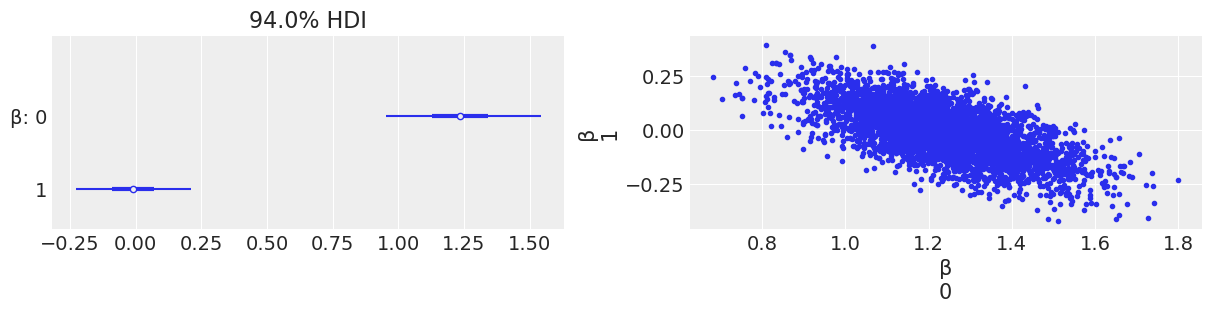

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12, 3),  constrained_layout=True)

az.plot_forest(trace_red, var_names=['β'], combined=True, ax=axes[0])
az.plot_pair(trace_red, var_names=['β'], ax=axes[1])
# plt.savefig('images/ch4/lr_mcol_trace.png')

## Masking effect variables

In [ ]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

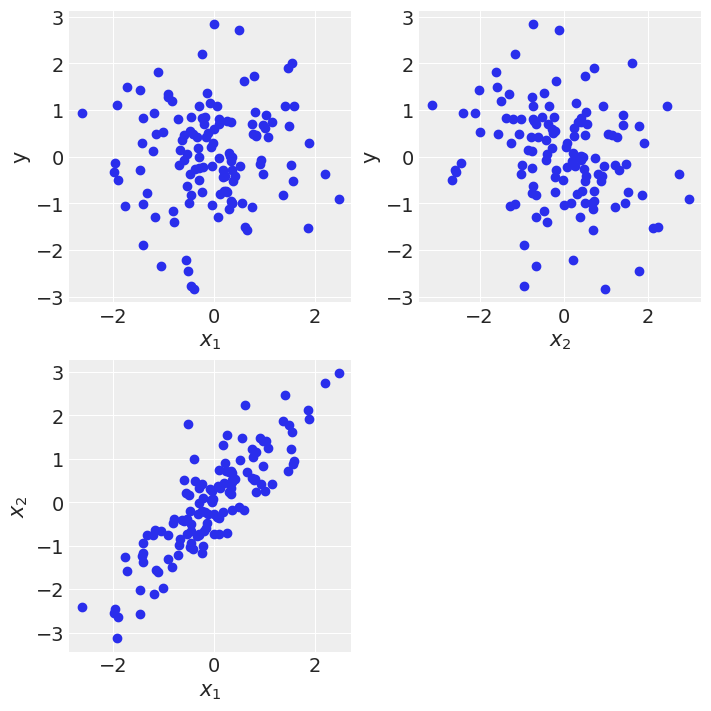

In [ ]:
scatter_plot(X, y)
# plt.savefig('images/ch4/mask_var.png')

In [ ]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    # trace_x1x2 = pm.sample(1000, return_inferencedata=True)
    # trace_x1x2.to_netcdf("data/ch4/lr_mask2.nc")
    trace_x1x2 = az.from_netcdf("../../data-pymc/ch4/lr_mask2.nc")

In [ ]:
with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    # trace_x1 = pm.sample(1000, return_inferencedata=True)
    # trace_x1.to_netcdf("data/ch4/lr_mask11.nc")
    trace_x1 = az.from_netcdf("../../data-pymc/ch4/lr_mask11.nc")

In [ ]:
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    # trace_x2 = pm.sample(1000, return_inferencedata=True)
    # trace_x2.to_netcdf("data/ch4/lr_mask12.nc")
    trace_x2 = az.from_netcdf("../../data-pymc/ch4/lr_mask12.nc")

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

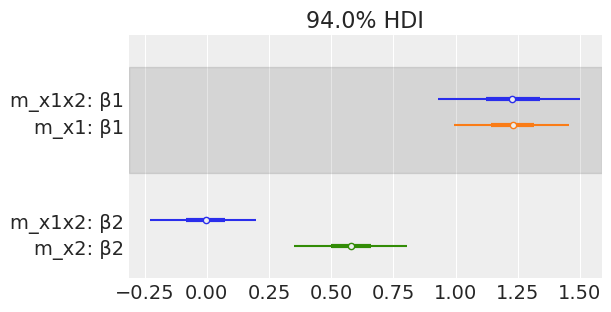

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(6, 3))
# plt.savefig('images/ch4/mask_forest.png')

## Variable variance

In [ ]:
babies = pd.read_csv('../data/babies.csv')
babies.head()

Month  Lenght
0      0    48.5
1      0    50.5
2      0    50.5
3      0    52.0
4      0    47.5

<AxesSubplot:xlabel='Month', ylabel='Lenght'>

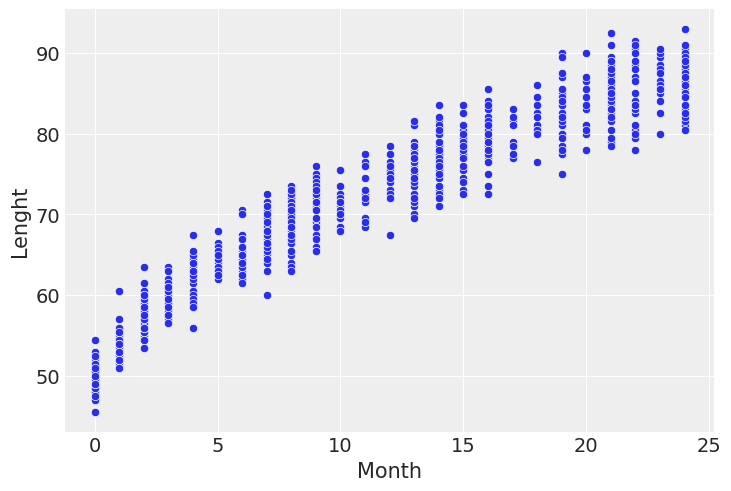

In [ ]:
sns.scatterplot(data=babies, x='Month', y='Lenght')

In [ ]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    x_shared = shared(babies['Month'].values * 1.)

    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=babies['Lenght'])

    # trace_vv = pm.sample(1000, tune=1000, return_inferencedata=True)
    # trace_vv.to_netcdf("data/ch4/lr_vv.nc")
    trace_vv = az.from_netcdf("../../data-pymc/ch4/lr_vv.nc")

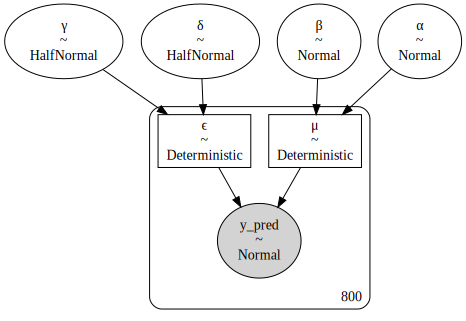

In [ ]:
pm.model_to_graphviz(model_vv)

In [ ]:
μ_m = trace_vv.posterior['μ'].mean(axis=0).mean(axis=0).values
ϵ_m = trace_vv.posterior['ϵ'].mean(axis=0).mean(axis=0).values

In [ ]:
babies['Month'].shape

(800,)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

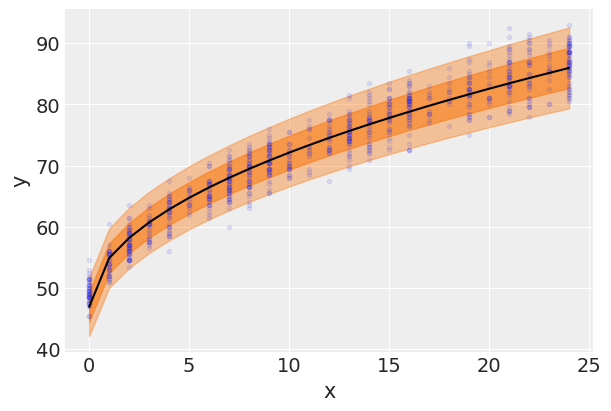

In [ ]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.plot(babies['Month'], babies['Lenght'], 'C0.', alpha=0.1)
ax.plot(babies['Month'], μ_m, c='k')
ax.fill_between(babies['Month'],
                μ_m + 1 * ϵ_m,
                μ_m - 1 * ϵ_m,
                alpha=0.6,
                color='C1')
ax.fill_between(babies['Month'],
                 μ_m + 2 * ϵ_m,
                 μ_m - 2 * ϵ_m,
                 alpha=0.4,
                 color='C1')

ax.set(xlabel='x', ylabel='y')

In [ ]:
with model_vv:
    x_shared.set_value([0.5])
    ppc = pm.sample_posterior_predictive(trace_vv, 2000)
    y_ppc = ppc['y_pred'][:, 0]

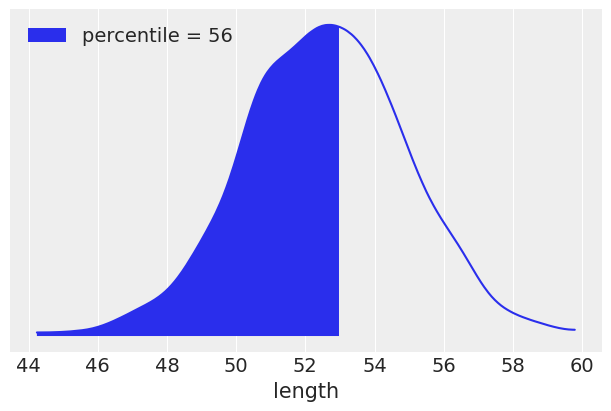

In [ ]:
ref = 53
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

grid, pdf = az.kde(y_ppc)

ax.plot(grid, pdf)
ax.fill_between(grid[grid < ref],
                pdf[grid < ref],
                label=f'percentile = {percentile:2d}')
ax.set(xlabel='length', yticks=[])
ax.legend(loc=2)
# plt.savefig('images/ch4/variance_dist.png')

In [ ]:
x_4 = ans.query("group == 'IV'")['x']
y_4 = ans.query("group == 'IV'")['y']

with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    # ν = pm.Exponential('ν', 1/30)
    ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sd=ϵ, nu=ν, observed=y_4)
    # trace_t2 = pm.sample(2000, return_inferencedata=True)
    # trace_t2.to_netcdf("data/ch4/lr_vv_t.nc")
    trace_t2 = az.from_netcdf("../../data-pymc/ch4/lr_vv_t.nc")

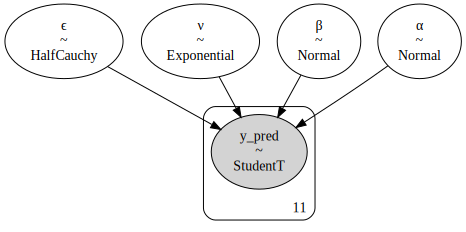

In [ ]:
pm.model_to_graphviz(model_t2)